## 4. Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### 4.1 Import Libraries and Load Datas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler


from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read the cleaned and dummy-encoded train data

train_cleaned = pickle.load(open(r"U:\arvato_data\train_cleaned.pickle", "rb"))

In [4]:
# Read the cleaned and dummy-encoded test data

test_cleaned = pickle.load(open(r"U:\arvato_data\test_cleaned.pickle", "rb"))

### 4.2 Feature Scaling of Train Data

In [5]:
train_cleaned.shape

(34165, 614)

In [6]:
# Create labels from Response column of Train data
y = train_cleaned.RESPONSE
y.shape,y[y ==1].shape

((34165,), (423,))

In [7]:
# Drop Response column from train data and create X data
X = train_cleaned.drop(columns = "RESPONSE", axis = 1, inplace = False)
X.shape

(34165, 613)

In [8]:
# Apply scaling to X data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X.head(3)

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_DIREKT,...,CJT_KATALOGNUTZER_2.0,CJT_KATALOGNUTZER_3.0,CJT_KATALOGNUTZER_4.0,CJT_KATALOGNUTZER_5.0,UMFELD_ALT_2.0,UMFELD_ALT_3.0,UMFELD_ALT_4.0,UMFELD_ALT_5.0,HEALTH_TYP_2.0,HEALTH_TYP_3.0
0,0.554097,-0.132703,-0.220702,-0.751759,0.477006,-0.091371,-0.051604,0.338352,0.010117,-0.427354,...,-0.272525,-0.410309,-0.440023,1.050167,2.018293,-0.609674,-0.525814,-0.366824,1.025407,-0.543376
1,-0.377802,-0.132703,-0.220702,-0.018542,-0.369718,-0.091371,-1.017668,0.338352,0.010117,-0.427354,...,3.669392,-0.410309,-0.440023,-0.952230,2.018293,-0.609674,-0.525814,-0.366824,1.025407,-0.543376
2,-0.444366,0.000445,-0.220702,-1.484976,-0.369718,-0.091371,0.914459,-1.483091,-1.228820,-0.427354,...,-0.272525,-0.410309,-0.440023,1.050167,-0.495468,-0.609674,-0.525814,-0.366824,-0.975223,-0.543376


### 4.3 Building Classification Model

I wll create classification model by comparing 4 models through Grid Search Cross Validation. 
I will find the best model that gives best auc-roc score; after i will tune the hyperparameters of selected model.
Finally i will fit the model and make the predictions.

In [375]:
# Create a dict to store the classifier names and models
random_state = 42
classifiers = {"DecisionTreeClassifier":DecisionTreeClassifier(random_state = random_state),
             "RandomForestClassifier":RandomForestClassifier(random_state = random_state),
             "AdaBoostClassifier":AdaBoostClassifier(random_state = random_state),
             "GradientBoostingClassifier":GradientBoostingClassifier(random_state = random_state) 
             }

# Create a list to store empty dicts of parameters
classifier_params = [ {} for i in range(len(classifiers)) ]


In [377]:
def grid_search(X,y, classifiers, classifier_params, scoring = "roc_auc"):
    
    '''
    Input --> X : Dataframe,features of dataset
              y : Labels of dataset
              classifiers: list of classifiers to fit such as "DecisionTreeClassifier()"
              classifier_params : list of parameter of classifier models
              scoring: evaluation metric of model "roc_auc" or "accuracy" etc
    
    Output --> scores : list of the scores of the models
               best_estimators: List of the best estimators of models              
    
    '''
    classifier_list = list(classifiers.values())
    scores = []
    best_estimators = []
    for i in range(len(classifier_list)):
        clf = GridSearchCV(classifier_list[i], 
                           param_grid=classifier_params[i], 
                           cv = StratifiedKFold(n_splits = 5), 
                           scoring = scoring, 
                           n_jobs = -1,
                           verbose = 3,
                           return_train_score=True
                          )
        clf.fit(X,y)
        scores.append(clf.best_score_)
        best_estimators.append(clf.best_estimator_)
        print("Best score of {} : {}".format(classifier_list[i],clf.best_score_)) 
        print("Best estimator of {} : {}".format(classifier_list[i],clf.best_estimator_)) 
        
    return scores, best_estimators

In [193]:
# Grid Search with X and y data with scoring "roc_auc"
scores, best_estimators = grid_search(
                                       X,
                                       y,
                                       classifiers = classifiers, 
                                       classifier_params = classifier_params, 
                                       scoring = "roc_auc")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.3s finished


Best score of DecisionTreeClassifier(random_state=42) : 0.5057996763093754
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.8s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.4s finished


Best score of RandomForestClassifier(random_state=42) : 0.5663297904840835
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.5s remaining:   35.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.5s finished


Best score of AdaBoostClassifier(random_state=42) : 0.6649924852200984
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Best score of GradientBoostingClassifier(random_state=42) : 0.7034452557740594


In [197]:
best_estimators

[DecisionTreeClassifier(random_state=42),
 RandomForestClassifier(random_state=42),
 AdaBoostClassifier(random_state=42),
 GradientBoostingClassifier(random_state=42)]

In [194]:
# Create DataFrame for score results
scores_df = pd.DataFrame({"Classifier":list(classifiers.keys()),
                          "Scores": scores})
scores_df

,Classifier,Scores
0,DecisionTreeClassifier,0.505800
1,RandomForestClassifier,0.566330
2,AdaBoostClassifier,0.664992
3,GradientBoostingClassifier,0.703445


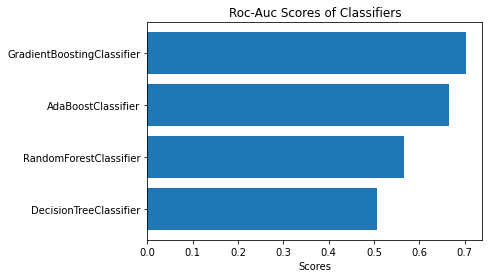

In [195]:
# Plot scores
plt.barh(scores_df.sort_values(by = "Scores").Classifier,
         scores_df.sort_values(by = "Scores").Scores)
plt.title("Roc-Auc Scores of Classifiers")
plt.xlabel("Scores")
plt.show()

So, as we see from above, best score has been achieved by Gradient Boosting Classifir.
This classifier is selected and to be tuned to increase the score. 

### 4.4 Hyperparameter tuning of Gradient Boosting Classifer

In [392]:
# Fitting GB Classifier and looking at parameters
gb_clf = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid={}, 
                      cv = StratifiedKFold(n_splits = 5), 
                      scoring = "roc_auc", 
                      n_jobs = -1,
                      verbose = 1,
                      return_train_score=True)
gb_clf.fit(X,y)
params = gb_clf.best_estimator_.get_params()
print("Best score of GB Classifier : {}".format(gb_clf.best_score_)) 
print("Parameters of GB classifier: {}".format(params))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


Best score of GB Classifier : 0.7034452557740594
Parameters of GB classifier: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


#### Tuninng the parameters:

Tuning the parameters as below, increased the score from 0.703 to 0.717

In [246]:
gb_clf = {"GradientBoostingClassifier":GradientBoostingClassifier(random_state = 42)}

In [378]:
t_gb_param_grid= [
    {
        'criterion': ["mse"],
        'max_depth': [1],
        'max_leaf_nodes' : [5],
        'n_estimators' :[38],
        'max_features' : ['auto'],
        'n_iter_no_change':[29],
        'learning_rate' : [0.145],
        'subsample':[1],
        'warm_start': ["True"],
        'min_samples_split':[0.01]       
    }
]

In [379]:
t_scores, t_best_estimators = grid_search(
                                       X,
                                       y,
                                       classifiers = gb_clf, 
                                       classifier_params = t_gb_param_grid, 
                                       scoring = "roc_auc")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   20.6s remaining:   30.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.2s finished


Best score of GradientBoostingClassifier(random_state=42) : 0.7169817661483524
Best estimator of GradientBoostingClassifier(random_state=42) : GradientBoostingClassifier(criterion='mse', learning_rate=0.145, max_depth=1,
                           max_features='auto', max_leaf_nodes=5,
                           min_samples_split=0.01, n_estimators=38,
                           n_iter_no_change=29, random_state=42, subsample=1,
                           warm_start='True')


In order to increase the score, i will increase the kfold number while fitting the best classifier in GridSearch:

In [380]:
best_gb_clf = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid= t_gb_param_grid, 
                      cv = StratifiedKFold(n_splits = 15), 
                      scoring = "roc_auc", 
                      n_jobs = -1,
                      verbose = 1,
                      return_train_score=True)
best_gb_clf.fit(X,y)
params = best_gb_clf.best_estimator_
print("Best score of Tuned GB Classifier : {}".format(best_gb_clf.best_score_)) 


Fitting 15 folds for each of 1 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.4min finished


Best score of Tuned GB Classifier : 0.7177439564982518


## 5. Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

### 5.1 Feature Scaling of Test Data

In [381]:
# Show head
test_cleaned.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_DIREKT,...,CJT_KATALOGNUTZER_2.0,CJT_KATALOGNUTZER_3.0,CJT_KATALOGNUTZER_4.0,CJT_KATALOGNUTZER_5.0,UMFELD_ALT_2.0,UMFELD_ALT_3.0,UMFELD_ALT_4.0,UMFELD_ALT_5.0,HEALTH_TYP_2.0,HEALTH_TYP_3.0
0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,6.0,2.0,0,...,0,0,0,1,1,0,0,0,0,0
1,20.0,0.0,0.0,1.0,21.0,0.0,4.0,7.0,5.0,0,...,0,0,0,1,0,0,1,0,1,0
2,2.0,0.0,0.0,4.0,2.0,0.0,4.0,1.0,7.0,0,...,0,0,0,1,0,0,0,0,1,0
3,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,2.0,0,...,0,0,0,1,1,0,0,0,1,0
4,1.0,0.0,0.0,4.0,1.0,0.0,3.0,6.0,5.0,2,...,0,0,0,0,0,0,0,1,1,0


In [382]:
# Show row & column count
test_cleaned.shape

(42833, 613)

In [383]:
# Apply scaling to X data
scaler = StandardScaler()
test_scaled = pd.DataFrame(scaler.fit_transform(test_cleaned), columns = test_cleaned.columns)
test_scaled.head(3)

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_DIREKT,...,CJT_KATALOGNUTZER_2.0,CJT_KATALOGNUTZER_3.0,CJT_KATALOGNUTZER_4.0,CJT_KATALOGNUTZER_5.0,UMFELD_ALT_2.0,UMFELD_ALT_3.0,UMFELD_ALT_4.0,UMFELD_ALT_5.0,HEALTH_TYP_2.0,HEALTH_TYP_3.0
0,-0.353063,-0.149514,-0.247607,-0.018874,-0.340189,-0.105655,-0.211076,0.674524,-1.419477,-0.386287,...,-0.256701,-0.376667,-0.400196,0.916162,2.308612,-0.81383,-0.459830,-0.338313,-1.137366,-0.484496
1,0.984863,-0.149514,-0.247607,-0.822656,1.151929,-0.105655,0.774537,1.153740,-0.069416,-0.386287,...,-0.256701,-0.376667,-0.400196,0.916162,-0.433161,-0.81383,2.174719,-0.338313,0.879225,-0.484496
2,-0.353063,-0.149514,-0.247607,1.588691,-0.340189,-0.105655,0.774537,-1.721553,0.830625,-0.386287,...,-0.256701,-0.376667,-0.400196,0.916162,-0.433161,-0.81383,-0.459830,-0.338313,0.879225,-0.484496


### 5.2 Getting Predictions from Tuned Model

In [384]:
# Getting predicted probabilities by Tuned GB classifier
#probability = ensemble.predict_proba(test_scaled)
probability = best_gb_clf.predict_proba(test_scaled)

In [385]:
# First 5 value in probability matris
probability[:5]

array([[0.9877776 , 0.0122224 ],
       [0.98856878, 0.01143122],
       [0.99434271, 0.00565729],
       [0.994446  , 0.005554  ],
       [0.99190128, 0.00809872]])

In [386]:
# Creating response values with column 1 of probability array.
# Column 0 indicates the probability of being label 0
# Column 1 indicated the probability of being label 1
probability_of_test = pd.DataFrame({"RESPONSE":probability[:,1]})
probability_of_test.max()

RESPONSE    0.996958
dtype: float64

In [387]:
probability_of_test.head()

,RESPONSE
0,0.012222
1,0.011431
2,0.005657
3,0.005554
4,0.008099


In [388]:
# Loading LNR column from original test data
LNR = pd.read_csv(r"U:\arvato_data\Udacity_MAILOUT_052018_TEST.csv", 
                     delimiter=";", usecols = ["LNR"])
LNR.head()

,LNR
0,1754
1,1770
2,1465
3,1470
4,1478


In [389]:
# Creating Kaggle data
kaggle = pd.concat([LNR, probability_of_test], axis = 1)
kaggle.head()

,LNR,RESPONSE
0,1754,0.012222
1,1770,0.011431
2,1465,0.005657
3,1470,0.005554
4,1478,0.008099


In [390]:
kaggle.RESPONSE.unique()

array([0.0122224 , 0.01143122, 0.00565729, ..., 0.01281577, 0.00663351,
       0.0072237 ])

In [391]:
kaggle.to_csv(r"U:\arvato_data\kaggle.csv", index = False)

#### With above submission, achieved public score is 0.63078.